In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import accuracy_score
import pickle
from IPython.display import clear_output
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from torch import optim

In [ ]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#BASIC IMPORTS AND DATASET READING

In [ ]:
dataf = pd.read_csv('Dataset Earthquake(3 greater).txt',error_bad_lines=False)
dataf.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR .1,TYPE,MAG
0,589363,NDI,1982-11-21,08:10:21,28.80,81.05,,,NDI,ML,3.6
1,500434,NDI,1986-03-13,20:58:43,28.60,80.60,,,NDI,mL,3.3
2,495770,NEIC,1986-05-16,05:16:13.70,34.00,72.58,15.0,TRUE,NEIC,mL,4.0
3,490430,QUE,1986-07-10,07:56:12,34.15,72.69,2.0,,QUE,mL,4.5
4,384489,BJI,1989-12-20,21:47:53.50,36.82,73.85,23.0,,BJI,mL,4.2


SIMPLE PREPROCESSING

In [ ]:
dataf = dataf.drop(["AUTHOR   .1","DEPFIX"],axis=1)

In [ ]:
dataf = dataf.rename(columns={'AUTHOR   ':'AUTHOR',
                              'DATE      ':'DATE',
                              'TIME       ':'TIME',
                              'LAT     ':'LATITUDE',
                              'LON      ':'LONGITUDE',
                              'TYPE  ':'TYPE',
                              'MAG ':'MAG'})

In [ ]:
def clean_column(data,colname):
    depth_list=[]
    for i in range(len(data)):

        if data.iloc[i][colname].strip()=='':
            depth_list.append(0)
        elif data.iloc[i][colname].strip()=='9999999999':
            depth_list.append(0)
        else:
            depth_list.append(float(data.iloc[i][colname].strip()))

    return depth_list

In [ ]:
dataf["DEPTH"] = clean_column(dataf,"DEPTH")

In [ ]:
dataf.columns

Index(['EVENTID', 'AUTHOR', 'DATE', 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH',
       'TYPE', 'MAG'],
      dtype='object')

#PREPROCESSING

Convert DATE to Usable format

In [ ]:
N = 50
threshold_min_mag = 3

In [ ]:
dataf["DATE"] = pd.to_datetime(dataf["DATE"])

In [ ]:
def get_root_energy(mag):
    energy = 11.8+(1.5*mag)
    energy = 10**energy
    return energy**0.5

TVAL,MEAN MAGNITUDE, ENERGY

In [ ]:
dataf["TVAL"] = 0
dataf["MEAN_MAG"] = 0
dataf["ENERGY"] = 0

In [ ]:
for i in range(N,len(dataf)):
    dataf.loc[i,("TVAL")] = dataf.iloc[i]["DATE"]-dataf.iloc[i-N]["DATE"]
    dataf.loc[i,("MEAN_MAG")] = sum(dataf.iloc[i-N:i]["MAG"])/N
    dataf.loc[i,("ENERGY")] = sum(get_root_energy(dataf.iloc[i-N:i]["MAG"]))/dataf.iloc[i]["TVAL"].days

In [ ]:
for i in range(len(dataf)):
    dataf.loc[i,"TVAL"] = int(str(dataf.iloc[i]["TVAL"]).split()[0])

In [ ]:
def no_of_events(dataf,mag,i,N=50):
    count=0
    if i-N<0:
        K=0
    else:
        K=i-N
    for j in range(K,i):
        if(dataf.iloc[j]["MAG"]>=mag):
            count+=1
    if count==0:
        count=1
    return count

In [ ]:
dataf["NO_OF_EVENTS"] = 1
for i in range(N,len(dataf)):
    dataf.loc[i,"NO_OF_EVENTS"] = no_of_events(dataf,dataf.iloc[i]["MAG"],i)

a and b values GUTENBERG RICHTER LAW

In [ ]:
min_mag = np.min(np.array(dataf["MAG"]))
mean_mag = np.mean(np.array(dataf["MAG"]))
b_VAL = np.log10(np.exp(1))/(mean_mag-min_mag)
b_VAL           #final

1.1104403023946299

In [ ]:
a_VAL = sum(np.log10(np.array(dataf["NO_OF_EVENTS"])) + b_VAL*(np.array(dataf["MAG"])))/len(dataf)      #final

In [ ]:
m = dataf.iloc[181]["MAG"]
print("NUMBER OF EVENTS(PREDICTED)",10**(a_VAL-(b_VAL*m)))
print("NUMBER OF EVENTS(DATA)",dataf.iloc[105]["NO_OF_EVENTS"])

NUMBER OF EVENTS(PREDICTED) 14.40038299382052
NUMBER OF EVENTS(DATA) 9


In [ ]:
dataf["b"] = b_VAL

ETA VALUE

In [ ]:
predicted = a_VAL-b_VAL*np.array(dataf["MAG"])
real = np.log10(np.array(dataf["NO_OF_EVENTS"])) 
dataf["ETA"] = 0
eta = (real-predicted)**2/N-1
dataf["ETA"] = eta

MAGNITUDE DEFICIT

In [ ]:
a_VAL/b_VAL

4.543166427122758

In [ ]:
dataf["MAG_DEF"]=0
M_exp = a_VAL/b_VAL
for i in range(N,len(dataf)):
    dataf.loc[i,"MAG_DEF"] = np.max(np.array(dataf.iloc[i-N:i]["MAG"]))
dataf["MAG_DEF"] = np.array(dataf["MAG_DEF"]) - M_exp

MU and C value

In [ ]:
def calc_mu(dataf,i,char_mag=3.5,N=50):
    count=0
    char_times=[]
    if i-N<0:
        K=0
    else:
        K=i-N
    for j in range(K,i):
        if(dataf.iloc[j]["MAG"]>=char_mag):
            count+=1
            if count>1:
                #print(dataf.iloc[j]["DATE"]-last_time)
                temp = dataf.iloc[j]["DATE"]-last_time
                temp = int(str(temp).split()[0])
                char_times.append(temp)
            last_time = dataf.iloc[j]["DATE"]
    if count==0:
        count=1
    mu = sum(np.array(char_times))/count
    if mu==0:
        mu=-100
    c = np.std(np.array(char_times))/mu
    if math.isnan(c):
        c=-100
    return mu,c

In [ ]:
dataf["MU"] = 0
dataf["c"] = 0
for i in range(N,len(dataf)):
    dataf.loc[i,"MU"],dataf.loc[i,"c"] = calc_mu(dataf,i)

REMOVE ILLEGAL ROWS

In [ ]:
count=0
rem_rows=[]
for i in range(len(dataf)):
    if dataf.iloc[i]["MU"]==-100:
        rem_rows.append(i)
        count+=1
    if dataf.iloc[i]["c"]==-100:
        rem_rows.append(i)
        count+=1
        
dataf = dataf.drop(rem_rows,axis=0)
print(count)

2


In [ ]:
k=30
req_mag=4.3
dataf["OUTPUT"] = 0
for i in range(len(dataf)-k):
    for j in range(i,i+k):
        if dataf.iloc[j]["MAG"]>=req_mag:
            dataf.loc[i,"OUTPUT"] = 1

In [ ]:
final_dataf = pd.DataFrame(dataf.loc[N:,("TVAL","MEAN_MAG","ENERGY","b","ETA","MAG_DEF","MU","c")])

In [ ]:
def func(x):
    return (x-x.min())/(x.max()-x.min())        

In [ ]:
final_dataf = final_dataf.aggregate(func,0)
final_dataf["b"] = b_VAL

In [ ]:
final_dataf

,TVAL,MEAN_MAG,ENERGY,b,ETA,MAG_DEF,MU,c
50,1,0.863799,0.000000,1.11044,2.817449e-01,0.571429,1.000000,0.360621
51,0.805451,0.870968,0.000030,1.11044,3.051178e-01,0.571429,0.796922,0.416747
52,0.795928,0.888889,0.000034,1.11044,3.744529e-01,0.571429,0.774890,0.423402
53,0.788705,0.888889,0.000035,1.11044,1.979879e-02,0.571429,0.767048,0.429292
54,0.582499,0.842294,0.000080,1.11044,1.979879e-02,0.571429,0.584417,0.505512
...,...,...,...,...,...,...,...,...
1558,0.016746,0.415771,0.004293,1.11044,2.439407e-04,0.500000,0.029006,0.174341
1559,0.0162535,0.412186,0.004419,1.11044,2.502833e-07,0.500000,0.029006,0.174341
1560,0.0159251,0.394265,0.004455,1.11044,5.074340e-03,0.500000,0.029590,0.176852
1561,0.0159251,0.390681,0.004444,1.11044,2.502833e-07,0.500000,0.029590,0.176852


In [ ]:
final_dataf = final_dataf.drop(929,axis=0)
dataf = dataf.drop(929,axis=0)

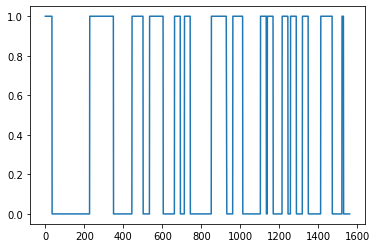

In [ ]:
plt.plot(dataf["OUTPUT"])
plt.show()

#DATA VISUALIZATION

GUTENBERG RICHTER LAW VISUALIZATION

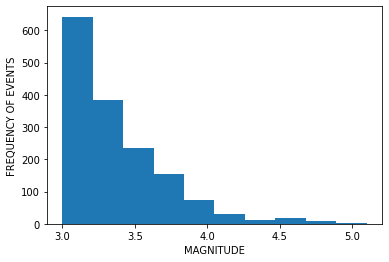

In [ ]:
plt.hist(dataf["MAG"])
plt.xlabel("MAGNITUDE")
plt.ylabel("FREQUENCY OF EVENTS")
plt.show()

T VALUES (SEISMICITY INDICATOR)

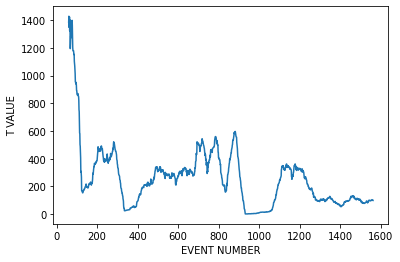

In [ ]:
plt.plot(dataf.loc[60:,("TVAL")])
plt.xlabel("EVENT NUMBER")
plt.ylabel("T VALUE")
plt.show()

MEAN MAGNITUDE (SEISMICITY INDICATOR)

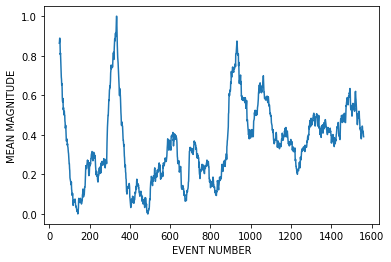

In [ ]:
plt.plot(final_dataf["MEAN_MAG"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MEAN MAGNITUDE")
plt.show()

ENERGY ((SEISMICITY INDICATOR)

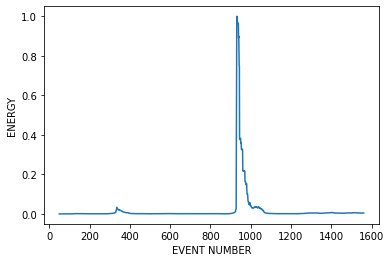

In [ ]:
plt.plot(final_dataf["ENERGY"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("ENERGY")
plt.show()

ETA VALUE (SEISMICITY INDICATOR)

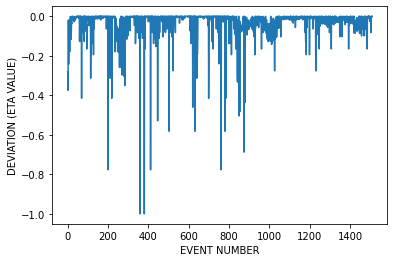

In [ ]:
plt.plot(np.array(final_dataf["ETA"])*-1)
plt.xlabel("EVENT NUMBER")
plt.ylabel("DEVIATION (ETA VALUE)")
plt.show()

MAGNITUDE DEFICIT (SEISMICITY INDICATOR)

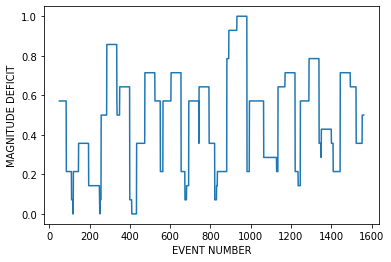

In [ ]:
plt.plot(final_dataf["MAG_DEF"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MAGNITUDE DEFICIT")
plt.show()

#MODEL

In [ ]:
arr_in = np.zeros((len(final_dataf),8))
arr_out = np.zeros((len(final_dataf),1)) 
for i in range(len(final_dataf)):
    arr_in[i] = np.array(final_dataf.iloc[i])
    arr_out[i] = dataf.iloc[i+N]["OUTPUT"]

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(arr_in,arr_out,random_state=0)

In [ ]:
X_train,X_val,Y_train,Y_val = map(torch.Tensor,(X_train,X_val,Y_train,Y_val))

In [ ]:
class earthquake_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8,24),
            nn.ReLU(),
            nn.Linear(24,24),
            nn.ReLU(),
            nn.Linear(24,12),
            nn.ReLU(),
            nn.Linear(12,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

In [ ]:
def fit_optim2(net,epochs=1000,lr=0.1,mini_batch=64,display=True,device="cpu"):
    loss_arr=[]
    accuracy_arr=[]
    torch.autograd.set_detect_anomaly(True)
    min_loss=10000
    opt.zero_grad()
    for i in range(epochs):
        j=0
        while j<len(X_train):
            y_hat = net(X_train[j:j+mini_batch,:])
            loss = loss_fn(y_hat.squeeze(),Y_train.squeeze()[j:j+mini_batch])    
            if loss<min_loss:
                min_loss=loss
                best_model=net
            loss.backward()
            j+=mini_batch
            opt.step()

        loss_arr.append(loss.item())

        if display and (i%5==0):
            clear_output(wait=True)
            print('Iteration',i,'Loss',loss_arr[-1])
            plt.figure()
            plt.plot(loss_arr[0:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
        
        

    print('The loss before training is' + str(loss_arr[0]))
    print('The loss after training is' + str(loss_arr[-1]))
    return loss_arr,best_model

In [ ]:
print(1)

1


In [ ]:
model = earthquake_model()
opt = optim.Adam(model.parameters(),lr=0.0001)
loss_fn = nn.BCELoss()

Iteration 1995 Loss 0.22672905027866364


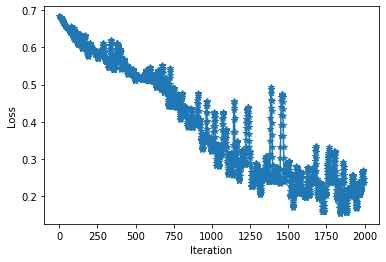




The loss before training is0.6839534044265747
The loss after training is0.19851984083652496


In [ ]:
l,bm = fit_optim2(model,2000)

In [ ]:
temp = bm(X_val)
for i in range(len(temp)):
    if temp[i]>0.5:
        temp[i]=1
    else:
        temp[i]=0
print("The accuracy after 2000 epochs is ",accuracy_score(temp.detach(),Y_val))

The accuracy after 2000 epochs is  0.9047619047619048


In [ ]:
torch.save(bm2,'Earthquake_Model_4(90.4%)')

In [ ]:
saved_model = torch.load("Earthquake_Model_4(90.4%)")

In [ ]:
temp = saved_model(X_val)
for i in range(len(temp)):
    if temp[i]>0.5:
        temp[i]=1
    else:
        temp[i]=0
print("The accuracy after 2000 epochs is ",accuracy_score(temp.detach(),Y_val)*100)

The accuracy after 2000 epochs is  90.47619047619048


In [ ]:
opt = optim.Adam(model.parameters(),lr=0.0000001)

Iteration 3995 Loss 0.1457221359014511


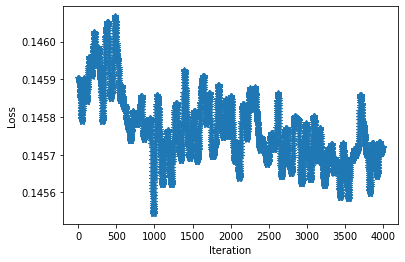




The loss before training is0.14590245485305786
The loss after training is0.1457282155752182


In [ ]:
l2,bm2 = fit_optim2(model,4000)

In [ ]:
temp2 = bm2(X_val)
for i in range(len(temp2)):
    if temp2[i]>0.5:
        temp2[i]=1
    else:
        temp2[i]=0
accuracy_score(temp2.detach(),Y_val)

0.9047619047619048